In [1]:
from xlayers import finegrid, layers
from xlayers.core import layers_numpy

In [2]:
import os
os.environ['NUMPY_EXPERIMENTAL_ARRAY_FUNCTION'] = '0'


from matplotlib import pyplot as plt
import numpy as np
import xarray as xr
import gcsfs

%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 6
%config InlineBackend.figure_format = 'retina' 

In [3]:
import pandas as pd
df = pd.read_csv('https://storage.googleapis.com/pangeo-cmip6/pangeo-cmip6-zarr-consolidated-stores.csv')
df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year
0,AerChemMIP,BCC,BCC-ESM1,ssp370,r1i1p1f1,Amon,pr,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/ssp370/r1i1...,NaN
1,AerChemMIP,BCC,BCC-ESM1,ssp370,r1i1p1f1,Amon,prsn,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/ssp370/r1i1...,NaN
2,AerChemMIP,BCC,BCC-ESM1,ssp370,r1i1p1f1,Amon,tas,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/ssp370/r1i1...,NaN
3,AerChemMIP,BCC,BCC-ESM1,ssp370,r1i1p1f1,Amon,tasmax,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/ssp370/r1i1...,NaN
4,AerChemMIP,BCC,BCC-ESM1,ssp370,r1i1p1f1,Amon,tasmin,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/ssp370/r1i1...,NaN


In [4]:
df_theta = df[(df.table_id == 'Omon') & (df.variable_id == 'thetao')]
uri = df_theta[(df_theta.source_id == 'SAM0-UNICON') &
                         (df_theta.experiment_id == 'historical')].zstore.values[0]
gcs = gcsfs.GCSFileSystem(token='anon')
ds_theta = xr.open_zarr(gcs.get_mapper(uri), consolidated=True)
df_salt = df[(df.table_id == 'Omon') & (df.variable_id == 'so')]
uri = df_salt[(df_salt.source_id == 'SAM0-UNICON') &
                         (df_salt.experiment_id == 'historical')].zstore.values[0]
gcs = gcsfs.GCSFileSystem(token='anon')
ds_salt = xr.open_zarr(gcs.get_mapper(uri), consolidated=True)
df_v = df[(df.table_id == 'Omon') & (df.variable_id == 'vo')]
uri = df_v[(df_v.source_id == 'SAM0-UNICON') &
                         (df_v.experiment_id == 'historical')].zstore.values[0]
gcs = gcsfs.GCSFileSystem(token='anon')
ds_v = xr.open_zarr(gcs.get_mapper(uri), consolidated=True)

In [5]:
import gsw
dens = xr.apply_ufunc(gsw.density.sigma0, ds_salt['so'], ds_theta['thetao'],
                      dask='parallelized', output_dtypes=[float, ]
                     ).rename('dens').to_dataset()

In [6]:
def finegrid_metrics(levs,lev_bnds):
    drF = np.diff(lev_bnds,axis=1)
    drC = np.concatenate((np.array([levs[0]]),np.diff(levs,axis=0),np.array([lev_bnds[-1,-1]-levs[-1]])))
    return(drF,drC)

In [7]:
fine_drf,fine_drc = finegrid_metrics(ds_theta.lev.values,ds_theta.lev_bnds.values)
print(finegrid.finegrid(np.squeeze(fine_drf), np.squeeze(fine_drc),[fine_drf.size,10]))

(array([0.16666667, 0.16666667, 0.16666667, ..., 4.1662083 , 4.1662083 ,
       4.1662083 ], dtype=float32), array([ 1,  1,  1, ..., 59, 59, 59], dtype=int32), array([1., 1., 1., ..., 0., 0., 0.], dtype=float32), array([ 1,  1,  1, ..., 60, 60, 60], dtype=int32))


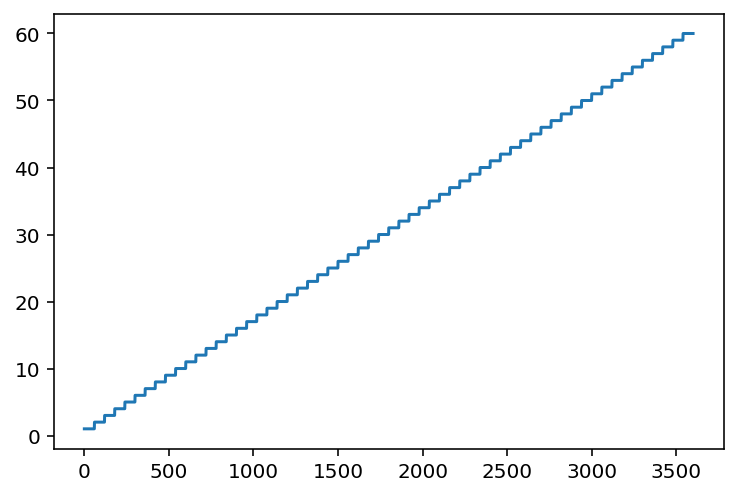

In [8]:
drf_finer, mapindex, mapfact, cellindex = finegrid.finegrid(np.squeeze(fine_drf),np.squeeze(fine_drc),[fine_drf.size,10])
plt.plot(cellindex)

In [9]:
thetalayers = np.linspace(-3,31,80)
VH = layers.layers_1(ds_v.vo[0,:,100,100].values, ds_theta.thetao[0,:,100,100].values,
                     thetalayers, mapfact, mapindex, cellindex, drf_finer)

In [10]:
v_in = ds_v.vo[0,:,:,:]#.transpose('lev','time','j','i')
theta_in = dens.dens[0,:,:,:]#.transpose('lev','time','j','i')

In [11]:
thetalayers = np.linspace(20,30,80)
v_lay1 = xr.apply_ufunc(layers_numpy, v_in, theta_in,#.chunk({'time': 2})
                       kwargs={'thetalayers':thetalayers,'mapfact':mapfact,
                               'mapindex':mapindex,'cellindex':cellindex,
                               'drf_finer':drf_finer},
                       dask='parallelized', 
                       input_core_dims=[['lev'],['lev']], output_core_dims=[['Tlev']],
                       output_dtypes=[float], output_sizes={'Tlev':thetalayers.size}
                       )
v_lay1 = v_lay1.assign_coords({'Tlev':thetalayers})

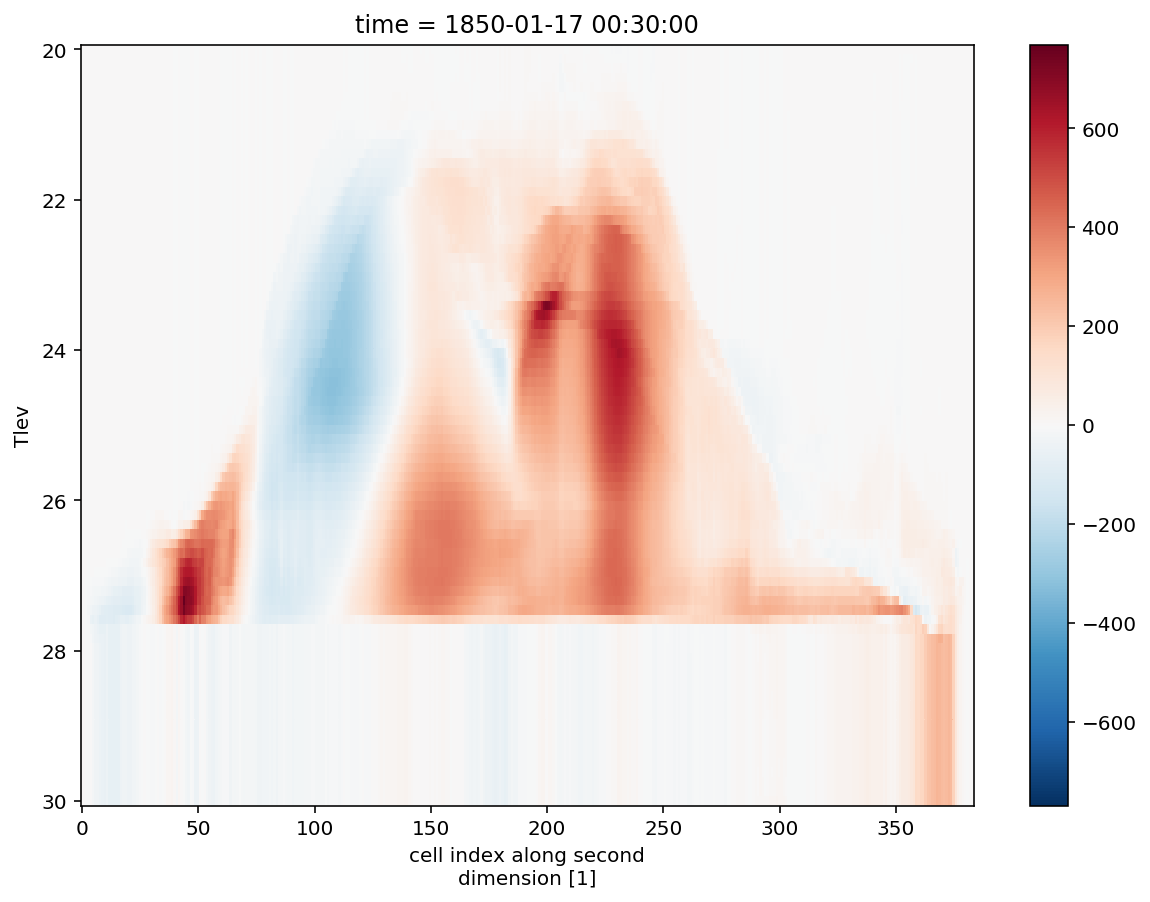

In [12]:
#Note: I have not summed with dx because I haven't had time to put it in
fig = plt.figure(figsize=(10,7))
(v_lay1).cumsum('Tlev').sum('i').plot(x='j',yincrease=False)